In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

*ktrain* uses TensorFlow 2.  To support sequence-tagging, *ktrain* also currently uses the CRF module from `keras_contrib`, which is not yet fully compatible with TensorFlow 2.
To use the BiLSTM-CRF model (which currently requires `keras_contrib`) for sequence-tagging in *ktrain*, you must disable V2 behavior in  TensorFlow 2
by adding the following line to the top of your notebook or script **before** importing *ktrain*:
```python
import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1'
```
Since we are employing a CRF layer in this notebook, we will set this value here:

In [2]:
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

In [3]:
import ktrain
from ktrain import text

Using DISABLE_V2_BEHAVIOR with TensorFlow


# Sequence Tagging

Sequence tagging (or sequence labeling) involves classifying words or sequences of words as representing some category or concept of interest.  One example of sequence tagging is Named Entity Recognition (NER), where we classify words or sequences of words that identify some entity such as a person, organization, or location.  In this tutorial, we will show how to use *ktrain* to perform sequence tagging in three simple steps.

## STEP 1: Load and Preprocess Data

The `entities_from_txt` function can be used to load tagged sentences from a text file.  The text file can be in one of two different formats: 1) the [CoNLL2003 format](https://www.aclweb.org/anthology/W03-0419) or 2) the [Groningen Meaning Bank (GMB) format](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). In both formats, there is one word and its associated tag on each line (where the word and tag are delimited by a space, tab or comma).  Words are ordered as they appear in the sentence.  In the CoNLL2003 format, there is a blank line that delineates sentences.  In the GMB format, there is a third column for Sentence ID that assignes a number to each row indicating the sentence to which the word belongs.  If you are building a sequence tagger for your own use case with the `entities_from_txt` function, the training data should be formatted into one of these two formats. Alternatively, one can use the `entities_from_array` function which simply expects arrays of the following form:
```python
x_train = [['Hello', 'world', '!'], ['Hello', 'Barack', 'Obama'], ['I', 'love', 'Chicago']]
y_train = [['O', 'O', 'O'], ['O', 'B-PER', 'I-PER'], ['O', 'O', 'B-LOC']]
```
Note that the tags in this example follow the [IOB2 format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

In this notebook, we will be using `entities_from_txt`  and build a sequence tagger using the Groningen Meaning Bank NER dataset available on Kaggle [here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). The format essentially looks like this (with fields being delimited by comma):
```
      SentenceID   Word     Tag    
      1            Paul     B-PER
      1            Newman   I-PER
      1            is       O
      1            a        O
      1            great    O
      1            actor    O
      1            .        O
 ```

We will be using the file `ner_dataset.csv` (which conforms to the format above) and will load and preprocess it using the `entities_from_txt` function.  The output is simlar to data-loading functions used in previous tutorials and includes the processed training set, processed validaton set, and an instance of `NERPreprocessor`.  

The Kaggle dataset `ner_dataset.csv` the three columns of interest (mentioned above) are labeled 'Sentence #', 'Word', and 'Tag'.  Thus, we specify these in the call to the function.

In [4]:
DATAFILE = '/home/amaiya/data/groningen_meaning_bank/ner_dataset.csv'
(trn, val, preproc) = text.entities_from_txt(DATAFILE,
                                             sentence_column='Sentence #',
                                             word_column='Word',
                                             tag_column='Tag', 
                                             data_format='gmb',
                                             use_char=True)

detected encoding: WINDOWS-1250 (if wrong, set manually)
Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-art', 'I-art', 'I-eve', 'B-geo', 'B-gpe', 'I-per', 'O', 'B-tim', 'I-gpe', 'B-nat', 'B-eve', 'B-org', 'I-nat', 'B-per', 'I-org', 'I-tim', 'I-geo']
Number of Labels:  17
Longest sentence: 104 words


When loading the dataset above, we specify `use_char=True` to instruct *ktrain* to extract the character vocabulary to be used in a character embedding layer of a model.

## STEP 2:  Define a Model

The `print_sequence_taggers` function shows that, as of this writing, *ktrain* currently supports both Bidirectional LSTM-CRM and Bidirectional LSTM as base models for sequence tagging. Theses base models can be used with different embedding schemes.

For instance, the `bilstm-transformer` model employs transformer embeddings like [BERT word embeddings](https://arxiv.org/abs/1810.04805) as features for a Bidirectional LSTM. See [this notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/CoNLL2002_Dutch-BiLSTM.ipynb) for an example of `bilstm-transformer`.  In this tutorial, we will use a Bidirectional LSTM model with a CRF layer. 

In [5]:
text.print_sequence_taggers()

bilstm: Bidirectional LSTM (https://arxiv.org/abs/1603.01360)
bilstm-transformer: Bidirectional LSTM w/ transformer embeddings (multlingual BERT is default)
bilstm-crf: Bidirectional LSTM-CRF  (https://arxiv.org/abs/1603.01360)
bilstm-elmo: Bidirectional LSTM w/ Elmo embeddings [English only]
bilstm-crf-elmo: Bidirectional LSTM-CRF w/ Elmo embeddings [English only]


In [6]:
WV_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
model = text.sequence_tagger('bilstm-crf', preproc, wv_path_or_url=WV_URL)

Embedding schemes employed (combined with concatenation):
	word embeddings initialized with fasttext word vectors (cc.en.300.vec.gz)
	character embeddings

pretrained word embeddings will be loaded from:
	https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
loading pretrained word vectors...this may take a few moments...


In the cell above, notice that we suppied the `wv_path_or_url` argument. This directs *ktrain* to initialized word embeddings with one of the pretrained fasttext (word2vec) word vector sets from [Facebook's fastttext site](https://fasttext.cc/docs/en/crawl-vectors.html).   When supplied with a valid URL to a `.vec.gz`, the word vectors will be automatically downloaded, extracted, and loaded in STEP 2 (download location is `<home_directory>/ktrain_data`). To disable pretrained word embeddings, set `wv_path_or_url=None` and randomly initialized word embeddings will be employed. Use of pretrained embeddings will typically boost final accuracy. When used in combination with a model that uses an embedding scheme like BERT (e.g., `bilstm-bert`), the different word embeddings are stacked together using concatenation.

Finally, we will wrap our selected model and datasets in a `Learner` object to facilitate training.

In [7]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

## STEP 3: Train and Evaluate the Model

Here, we will train for a single epoch using an initial learning rate of 0.01 with gradual decay using cosine annealing (via the `cycle_len=1`) parameter and see how well we do. The learning rate of `0.01` is determined with the learning-rate-finder (i.e., `lr_find`).

In [7]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train for 337 steps
Epoch 1/1024
337/337 [==============================] - 144s 426ms/step - loss: 1.2752
Epoch 2/1024
337/337 [==============================] - 138s 408ms/step - loss: 0.6956
Epoch 3/1024
337/337 [==============================] - 137s 407ms/step - loss: 0.2069
Epoch 4/1024
337/337 [==============================] - 136s 405ms/step - loss: 0.0684
Epoch 5/1024
160/337 [=============>................] - ETA: 1:12 - loss: 0.1804

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


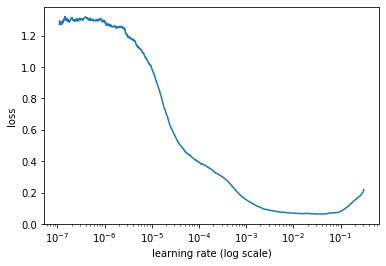

In [8]:
learner.lr_plot()

In [8]:
learner.fit(1e-2, 1, cycle_len=1)

preparing train data ...done.
preparing valid data ...done.
338/338 [==============================] - 123s 365ms/step - loss: 4.6233 - val_loss: 4.5265


In [9]:
learner.validate()

   F1: 84.19
           precision    recall  f1-score   support

      tim       0.90      0.86      0.88      2078
      geo       0.84      0.90      0.87      3728
      org       0.75      0.69      0.72      1981
      per       0.81      0.78      0.79      1717
      gpe       0.97      0.93      0.95      1540
      eve       0.60      0.21      0.31        29
      art       0.00      0.00      0.00        47
      nat       0.57      0.19      0.29        21

micro avg       0.85      0.84      0.84     11141
macro avg       0.84      0.84      0.84     11141



0.8418623591692684

Our F1-score is **84.19** after a single pass through the dataset. Not bad for a single epoch of training.

Let's invoke `view_top_losses` to see the sentence we got the most wrong. This single sentence about James Brown contains 10 words that are misclassified.  We can see here that our model has trouble with titles of songs. In addition, some of the ground truth labels for this example are sketchy and incomplete, which also makes things difficult.

In [12]:
learner.view_top_losses(n=1)

total incorrect: 10
Word            True : (Pred)
Mr.            :B-per (B-per)
Brown          :I-per (I-per)
is             :O     (O)
known          :O     (O)
by             :O     (O)
millions       :O     (O)
of             :O     (O)
fans           :O     (O)
as             :O     (O)
"              :O     (O)
The            :O     (O)
Godfather      :B-per (B-org)
of             :O     (O)
Soul           :B-per (B-per)
"              :O     (O)
thanks         :O     (O)
to             :O     (O)
such           :O     (O)
classic        :O     (O)
songs          :O     (O)
as             :O     (O)
"              :O     (O)
Please         :B-art (O)
,              :O     (O)
Please         :O     (B-geo)
,              :O     (O)
Please         :O     (O)
,              :O     (O)
"              :O     (O)
"              :O     (O)
It             :O     (O)
's             :O     (O)
a              :O     (O)
Man            :O     (O)
's             :O     (O)
World          :O   

## Making Predictions on New Sentences

Let's use our model to extract entities from new sentences. We begin by instantating a `Predictor` object.

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [14]:
predictor.predict('As of 2019, Donald Trump is still the President of the United States.')

[('As', 'O'),
 ('of', 'O'),
 ('2019', 'B-tim'),
 (',', 'O'),
 ('Donald', 'B-per'),
 ('Trump', 'I-per'),
 ('is', 'O'),
 ('still', 'O'),
 ('the', 'O'),
 ('President', 'B-per'),
 ('of', 'O'),
 ('the', 'O'),
 ('United', 'B-geo'),
 ('States', 'I-geo'),
 ('.', 'O')]

We can save the predictor for later deployment.

In [15]:
predictor.save('/tmp/mypred')

In [16]:
reloaded_predictor = ktrain.load_predictor('/tmp/mypred')

In [17]:
reloaded_predictor.predict('Paul Newman is my favorite American actor.')

[('Paul', 'B-per'),
 ('Newman', 'I-per'),
 ('is', 'O'),
 ('my', 'O'),
 ('favorite', 'O'),
 ('American', 'B-gpe'),
 ('actor', 'O'),
 ('.', 'O')]

The `predict` method also can accept a list of sentences.  And, larger batch sizes can potentially speed predictions when `predictor.predict` is supplied with a list of examples.

Both the `load_predictor` and `get_predictor` functions accept an optional `batch_size` argument used for predictions, which is set to 32 by default. The `batch_size` can also be set manually on the `Predictor` instance.  That is, the `batch_size` used for inference and predictions can be increased with either of the following:
```python
# you can set the batch_size as an argument to load_predictor (or get_predictor)
predictor = ktrain.load_predictor('/tmp/mypred', batch_size=128)

# you can also set the batch_size used for predictions this way
predictor.batch_size = 128
```


### A Note on Sentence Tokenization

The `predict` method typically operates on individual sentences instead of entire paragraphs or documents. The model after all was trained on individual sentences.  In production, you can use the `sent_tokenize` function to tokenize text into individual sentences.

```python
from ktrain import text
text.textutils.sent_tokenize('This is the first sentence about Dr. Smith.  This is the second sentence.')
```

The above will output:
```
['This is the first sentence about Dr . Smith .',
 'This is the second sentence .']
```

### Optional Arguments to `predictor.predict`

The `NERPredictor.predict` method includes the following optional parameters:

- **merge_tokens**:  When True, tokens of the same entity will be merged (e.g., `Paul Newman: "PERSON"`).
- **return_offsets**: When True, character offsets will be included in the results, which is useful for highlighting entities in the input sentence or displaying entities in their original form.

#### Example:
```python
text = '''
 75.5 mg Tablet, twice a day 
 1 mg/ml solution for injection in a pre-filled syringe
'''
prediction = predictor.predict(text, return_offsets=True, merge_tokens=True)

for entity in prediction:
    word = entity[0]
    label = entity[1]
    start = entity[2][0]
    end = entity[2][1]
    corrected_word = text[start:end]
    print(corrected_word ,label)
    
# OUTPUT
# 75.5 mg STRENGTH
# Tablet FORM
# 1 mg/ml STRENGTH
# solution for injection FORM
```